In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [59]:
df=pd.read_csv('flight_data.csv')

In [60]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date of Booking  452088 non-null  object
 1   Date of Journey  452088 non-null  object
 2   Airline-Class    452088 non-null  object
 3   Departure Time   452088 non-null  object
 4   Arrival Time     452088 non-null  object
 5   Duration         452088 non-null  object
 6   Total Stops      452088 non-null  object
 7   Price            452088 non-null  object
dtypes: object(8)
memory usage: 27.6+ MB


In [62]:
df.isnull().sum()

Date of Booking    0
Date of Journey    0
Airline-Class      0
Departure Time     0
Arrival Time       0
Duration           0
Total Stops        0
Price              0
dtype: int64

# Data Cleaning

In [63]:
def clean_flight_data(df):
    
    #Airline Class
    df['Airline-Name']=df['Airline-Class'].str.split('\n').str[0].str.strip()

     
    df['Class'] = df['Airline-Class'].str.split('\n').str[-1].str.strip()
    
    #journey date
    df['Date of Journey']=pd.to_datetime(df['Date of Journey'],format='%d/%m/%Y')
    
    #date of booking 
    df['Date of Booking']=pd.to_datetime(df['Date of Booking'],format='%d/%m/%Y')
    
    #days before flight
    df['days_before_flight']=(df['Date of Journey']-df['Date of Booking']).dt.days
    
    # day of booking
    df['journey_day']=df['Date of Journey'].dt.day
    
    df['journey_day_name']=df['Date of Journey'].dt.day_name()
    
   
    
    # Departure City
    df['Departure City']=df['Departure Time'].str.split('\n').str[1].str.strip()    
    
    # Arrival City
    df['Arrival City']=df['Arrival Time'].str.split('\n').str[1].str.strip()
    
    
    #TotalStops Cleanup
    df['Total Stops'] = df['Total Stops'].str.replace(r'\n\s*\t*', '', regex=True)
    df['Total Stops'] = df['Total Stops'].str.replace(r'(stop).*', r'\1', regex=True)
    
    #Departure Time
    df['Departure_Time']=df['Departure Time'].str.split('\n').str[0].str.strip()
    
    #Arrival Time
    df['Arrival_Time']=df['Arrival Time'].str.split('\n').str[0].str.strip()
    
    #Duration
    df['Duration'] = df['Duration'].str.extract(r'(\d+)h (\d+)m') \
                                     .astype(float) \
                                     .apply(lambda x: round(x[0] + x[1] / 60, 4), axis=1)
    # Extract hour from 'arrival' column
    df['arrival_time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour

    # Categorize arrivals based on the hour
    df['arrival_category'] = df['arrival_time'].apply(lambda x: 'Before 7pm' if x < 19 else 'After 7pm')
                            
    #drop columns
    df.drop(['Date of Booking','Date of Journey','Airline-Class','Departure Time','Arrival Time','arrival_time'],axis=1,inplace=True)
                            
    df['Price'] = df['Price'].replace(',', '', regex=True).astype(int)
    return df

In [64]:
df = clean_flight_data(df)

In [65]:
df.sample(4)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,Departure City,Arrival City,Departure_Time,Arrival_Time,arrival_category
142744,1.9167,non-stop,5864,Indigo,ECONOMY,10,25,Wednesday,Mumbai,Chennai,10:15,12:10,Before 7pm
416786,7.5000,1-stop,16371,Air India,ECONOMY,12,27,Friday,Ahmedabad,Mumbai,14:40,22:10,After 7pm
108608,13.8333,1-stop,10794,Air India,ECONOMY,29,13,Monday,Mumbai,Bangalore,21:05,10:55,Before 7pm
315024,6.8333,1-stop,10497,Indigo,ECONOMY,41,25,Saturday,Kolkata,Mumbai,17:25,00:15,Before 7pm


## Feature Engineering

In [66]:
def feat_eng(df):
    #concatenate route
    df['Route'] = df['Departure City'] + ' -> ' + df['Arrival City']
    
    #drop appended columns above
    df.drop(['Departure City','Arrival City'],axis=1,inplace=True)
    
    
    ## Convert Departure and Arrival to the hr
    df['Departure_Time_hr']=pd.to_datetime(df['Departure_Time'], format='%H:%M').dt.hour
    df['Arrival_Time_hr']=pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour
    
    df.drop(['Departure_Time','Arrival_Time'],axis=1,inplace=True)
    
    
    
    return(df)
    

In [67]:
df=feat_eng(df)

In [68]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
68703,15.1667,1-stop,12004,Vistara,PREMIUMECONOMY,32,16,Thursday,Before 7pm,Delhi -> Chennai,17,8
422883,10.8333,1-stop,8842,Vistara,ECONOMY,49,5,Sunday,Before 7pm,Ahmedabad -> Mumbai,6,17


In [69]:
df=df[(df['Airline-Name']=='Air India') & (df['Class']=='ECONOMY')  & (df['Route']=='Delhi -> Mumbai') ]

In [70]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
7315,17.1667,1-stop,7415,Air India,ECONOMY,20,4,Saturday,After 7pm,Delhi -> Mumbai,6,23
11238,13.5833,1-stop,7194,Air India,ECONOMY,30,14,Tuesday,After 7pm,Delhi -> Mumbai,9,23


In [71]:
# drop airline name and class after filtering
df.drop(['Class','Airline-Name','Route'],inplace=True,axis=1)

######  Encoding

In [72]:
def enc_data(df):
    # Total Stops
    df=pd.get_dummies(df, columns=['Total Stops'], prefix='Stops',dtype=int)  
      

    
    # frequency coding journey day name
    frequency_map = df['journey_day_name'].value_counts(normalize=True).to_dict()
    df['journey_day_name_FreqEnc'] = df['journey_day_name'].map(frequency_map)
    
    df.drop(['journey_day_name'],axis=1,inplace=True)
    
    #label encoding arrival_category
    label_encoder = LabelEncoder()
    df['arrival_category'] = label_encoder.fit_transform(df['arrival_category'])
    
        
    return (df)    

In [73]:
enc_df=enc_data(df)

In [74]:
enc_df.sample(3)

,Duration,Price,days_before_flight,journey_day,arrival_category,Departure_Time_hr,Arrival_Time_hr,Stops_1-stop,Stops_non-stop,journey_day_name_FreqEnc
12776,7.8333,15405,34,18,0,15,22,1,0,0.147027
6577,26.3333,8614,18,2,1,22,0,1,0,0.122218
18039,11.7500,7194,48,4,0,9,21,1,0,0.147027


## Modeling - Xgboost Regressor

In [75]:
# Predictor & target variables
X=enc_df.drop(['Price',],axis=1)
y=enc_df['Price']
    
#split the dataset for train&test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
    

In [76]:
def xgboostmodel(enc_df):
    
    
    model = xgb.XGBRegressor(learning_rate= 0.06375277732583517, 
                             max_depth= 7, 
                             subsample= 0.7753243552829342, 
                             colsample_bytree= 0.7687203075487558,
                             min_child_weight=1)
    model.fit(X_train, y_train)

    
    return model

In [77]:
model = xgboostmodel(enc_df)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7687203075487558, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06375277732583517, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
predicted_prices=model.predict(X_test)
predicted_prices

array([13973.772 ,  9086.933 ,  7850.3003,  8395.266 ,  6509.047 ,
        7722.0137,  6957.4844,  8087.221 , 10247.53  , 12950.186 ,
        6000.23  ,  6769.697 ,  6145.336 ,  7697.631 ,  6390.1714,
        7699.466 ,  7993.332 ,  7260.3765,  6053.9414,  9915.387 ,
        8790.593 ,  5954.9175,  6032.4517,  7460.3374,  7917.1416,
       15736.232 ,  6507.103 , 12128.311 , 15487.259 ,  6019.8525,
        7836.195 ,  9665.8955,  9206.457 ,  7874.9575, 19127.885 ,
        8458.091 ,  7066.218 ,  8741.851 , 11973.253 ,  9654.655 ,
        7522.1445,  8478.19  ,  8308.791 , 13295.341 ,  5853.703 ,
        6145.67  ,  9062.856 , 11418.024 ,  7620.305 , 16316.545 ,
        6649.2485,  7946.665 ,  7888.0625,  7351.373 ,  8162.506 ,
        8303.255 ,  8050.8594,  5926.854 , 11351.827 , 11416.362 ,
       10096.438 ,  8321.024 ,  9321.827 ,  9783.316 ,  8293.053 ,
        8962.187 ,  8706.86  , 10348.265 ,  8788.029 ,  9437.172 ,
        9928.408 ,  8936.711 ,  8409.274 ,  9037.412 , 15282.8

In [79]:
r2 = r2_score(y_test, predicted_prices)
print('r2 is',r2)

rmse = mean_squared_error(y_test,predicted_prices, squared=False)
print('rmse is',rmse)

r2 is 0.826378089302004
rmse is 1529.1273902248581


## Feature Importance

In [80]:
# Get feature importance scores
feature_importance =model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
6,Stops_1-stop,0.444530
7,Stops_non-stop,0.133910
5,Arrival_Time_hr,0.119563
3,arrival_category,0.095229
0,Duration,0.068852
4,Departure_Time_hr,0.063294
1,days_before_flight,0.042904
8,journey_day_name_FreqEnc,0.016497
2,journey_day,0.015220


## Hyper Parameter Tuning

In [81]:
#!pip install optuna
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
        
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [82]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-07-23 11:25:38,654] A new study created in memory with name: no-name-f1354794-cc2a-4626-b7f9-c468f35bb05c
[I 2024-07-23 11:25:38,733] Trial 0 finished with value: 1990.228806892983 and parameters: {'learning_rate': 0.07621814216866511, 'max_depth': 2, 'subsample': 0.35156416784328187, 'colsample_bytree': 0.9700436241076826, 'min_child_weight': 4}. Best is trial 0 with value: 1990.228806892983.
[I 2024-07-23 11:25:38,877] Trial 1 finished with value: 1722.8157231648315 and parameters: {'learning_rate': 0.045655259575971864, 'max_depth': 7, 'subsample': 0.5123947135983491, 'colsample_bytree': 0.23973787805093172, 'min_child_weight': 14}. Best is trial 1 with value: 1722.8157231648315.
[I 2024-07-23 11:25:38,964] Trial 2 finished with value: 2112.48005453781 and parameters: {'learning_rate': 0.02395028159166653, 'max_depth': 3, 'subsample': 0.560831996747341, 'colsample_bytree': 0.7466776654977136, 'min_child_weight': 11}. Best is trial 1 with value: 1722.8157231648315.
[I 2024-07

In [83]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)



Best hyperparameters: {'learning_rate': 0.0614858521611923, 'max_depth': 9, 'subsample': 0.6707842512475604, 'colsample_bytree': 0.8576224047296794, 'min_child_weight': 5}
Best RMSE: 1375.4283736316838


In [84]:
import numpy as np
from scipy.optimize import minimize

# Calculate revenue before optimization
revenue_before = np.sum(predicted_prices)

# Define the objective function (maximize revenue)
def objective_function(prices):
    revenue = -np.sum(prices)  
    return revenue

# Define constraints
def constraint(prices, predicted_prices, min_revenue):
    return np.concatenate([prices - predicted_prices, predicted_prices * 1.2 - prices, [np.sum(prices) - min_revenue]])

# Define initial prices (use predicted prices as initial guess)
initial_prices = predicted_prices

# Minimum revenue constraint
min_revenue = np.sum(predicted_prices) * 0.9  



# Adjust constraints to ensure prices are no lower than predicted and no greater than 1.2 times predicted
bounds = [(price, price * 1.2) for price in predicted_prices]

# Perform optimization
result = minimize(objective_function, initial_prices, constraints={'type': 'ineq', 'fun': constraint, 'args': (predicted_prices, min_revenue)}, bounds=bounds)

# Get optimized prices
optimized_prices = result.x

# Calculate revenue after optimization
revenue_after = np.sum(optimized_prices)

# Print revenue before and after optimization
print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)


Revenue before optimization: 5200284.5
Revenue after optimization: 6239057.834539006


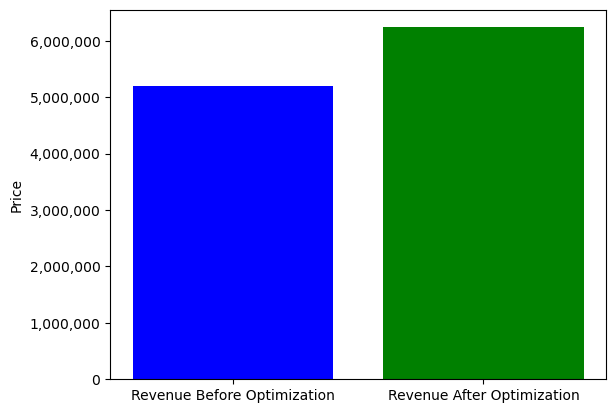

In [85]:
# Define revenue before and after optimization
revenue_values = [revenue_before, revenue_after]

# Define labels for the bars
labels = ['Revenue Before Optimization', 'Revenue After Optimization']


# Plotting
plt.bar(labels, revenue_values, color=['blue', 'green'])
plt.ylabel('Price')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [86]:
prices_df = pd.DataFrame({
    'Predicted Prices': predicted_prices,
    'Optimized Prices': optimized_prices
})
prices_df

,Predicted Prices,Optimized Prices
0,13973.772461,16768.526953
1,9086.932617,10904.319141
2,7850.300293,9420.360352
3,8395.265625,10074.318750
4,6509.046875,7810.856250
5,7722.013672,9266.416406
6,6957.484375,8348.981250
7,8087.221191,9704.665430
8,10247.530273,12297.036328
9,12950.185547,15540.222656


Text(0.5, 1.0, 'Distribution of Predicted and Optimized Prices')

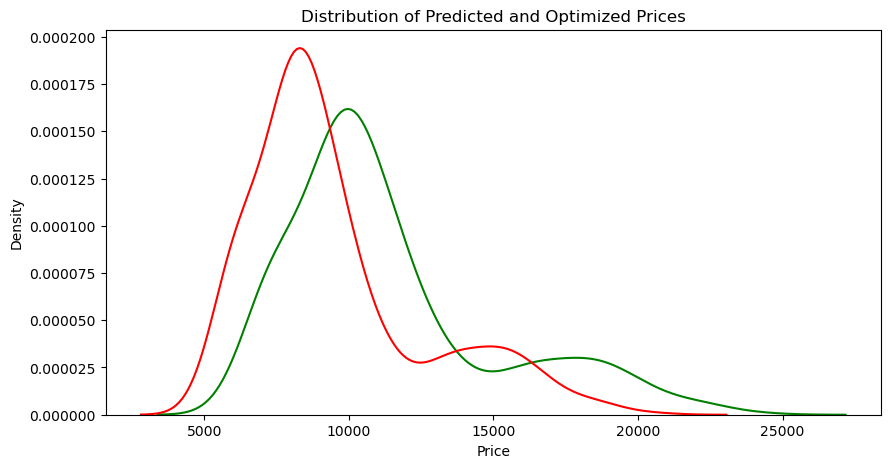

In [87]:
from matplotlib.pyplot import figure

#set size
figure(figsize=(10,5))
 
sns.kdeplot(x=optimized_prices, label='Optimized Prices',color='green')
sns.kdeplot(x=predicted_prices, label='Predicted Prices',color='red')

plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Predicted and Optimized Prices')